<a href="https://colab.research.google.com/github/Isak-Petrin/distributional_RL_python/blob/main/Welcome_to_Colab.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [7]:
!pip install gymnasium
!pip install pygame

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 14.0/14.0 MB 86.3 MB/s eta 0:00:00


In [2]:
from enum import Enum
import gymnasium as gym
from gymnasium import spaces
import pygame
import numpy as np
from gymnasium.envs.registration import register
import math

class RandomWalk(gym.Env):
    def __init__(
        self,
        param: dict | None = None,
      ):
        self.l = 7
        self.start = self.l // 2
        self.observation_space = gym.spaces.Discrete(self.l)
        self.action_space = gym.spaces.Discrete(2)

    def _get_obs(self):
        return self.state
    def _get_info(self):
        return {'l': self.l}


    def reset(self,seed=None, options=None):
        self.state = self.start
        obs = self._get_obs()
        info = self._get_info()
        return obs,info

    def step(self, action: int):

        self.done = False
        self.reward = -0.1

        if action:
            self.state += 1
        else:
            self.state -= 1

        if self.state in (0, self.l - 1):
            self.done = True
            self.reward = np.random.normal(loc = 20)

        obs = self._get_obs()
        info = self._get_info()

        return obs, self.reward, self.done, False, info



In [5]:
import gymnasium as gym
import sys
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm
import copy

class O_CatTD:
    def __init__(
        self,
        env: gym.Env,
        alpha: float,
        theta_range: list[int,int],
        resolution: int,
        policy: int,
        gamma: float,
    ):
        self.alpha = alpha
        self.gamma = gamma
        self.env = env
        self.min_theta = theta_range[0]
        self.max_theta = theta_range[1]
        self.resolution = resolution
        self.theta_lst = np.linspace(self.min_theta, self.max_theta, resolution)
        self.m = len(self.theta_lst)
        self.p = [np.ones(self.m) * (1/self.m) for _ in range(self.env.observation_space.n)]
        self.policy = policy
        self.plot_lst = []


    def find_i_star(self,g):
        bool_lst = self.theta_lst <= g
        i_star = np.where(bool_lst)[0].max()
        return i_star


    def learn_distribution(self, n_episodes: int):
        for episode in tqdm(range(n_episodes)):

            obs, info = self.env.reset()
            s = obs
            if self.policy:
                a = 1
            else:
                a = 0
            done = False

            t = 0
            while not done:
                p_tilde = np.zeros(self.m, dtype=np.float64)
                next_obs, reward, done, _ , info, = self.env.step(a)
                sn = next_obs
                for j in range(self.m):
                    if done:
                        g = reward
                    else:
                        g = reward + self.gamma * self.theta_lst[j]
                    if g <= self.min_theta:
                        p_tilde[0] += self.p[sn][j]
                    elif g >= self.max_theta:
                        p_tilde[self.m - 1] += self.p[sn][j]
                    else:
                        i_star = self.find_i_star(g)
                        zeta = (g - self.theta_lst[i_star]) / (self.theta_lst[i_star + 1] - self.theta_lst[i_star])
                        p_tilde[i_star] += (1-zeta) * self.p[sn][j]
                        p_tilde[i_star + 1] += zeta * self.p[sn][j]


                for i in range(self.m):
                    self.p[s][i] = (1 - self.alpha) * self.p[s][i] + self.alpha * p_tilde[i]

            self.plot_lst.append(np.array(copy.deepcopy(self.p)))






toy_env = RandomWalk()

catTD = O_CatTD(env = toy_env, alpha = 0.05,theta_range=[1,10],resolution = 10, policy = 1, gamma=0.95)
catTD.learn_distribution(10001)



  0%|          | 0/10001 [00:00<?, ?it/s]


TypeError: 'int' object is not subscriptable

In [1]:
from tqdm import tqdm
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import norm
from scipy.signal import savgol_filter
class quantile:
    def __init__(self, m: int):
        self.m = m
        self.theta = np.linspace(-2,2,self.m)

    def get_theta(self):
        return self.theta
    def set_theta(self,theta):
        self.theta = theta
    def add_theta(self, diff):
        self.theta += diff
    def sample(self):
        return np.random.choice(self.theta)
    def mean(self):
        return np.mean(self.theta)

class container:
    def __init__(self, x0):
        self.hist = []
        self.xs = [x0]
        self.rs = []
        self.ds = []

    def add(self, obs: tuple):
        self.hist.append(obs)
        self.xs.append(obs[0])
        self.rs.append(obs[1])
        self.ds.append(obs[2])

    def get_xs(self):
        return self.xs
    def get_rs(self):
        return self.rs
    def get_x(self,t):
        return self.xs[t]
    def get_d(self,t):
        return self.ds[t]

    def reset(self, x0):
        self.hist = []
        self.xs = [x0]
        self.rs = []
        self.ds = []


class QRTDlAgent:
    def __init__(self, m: int, l: float ,obs_space: int, gamma: float, alpha: float, x0, bootstrap: bool, kappa: bool):
        self.m = m
        self.l = l
        self.bootstrap = bootstrap
        self.q = {x: quantile(m = self.m) for x in range(obs_space)}
        self.tau = np.asarray([(2*i - 1) / (2*self.m) for i in range(1,self.m+1)])
        self.gamma = gamma
        self.N = {x: 0 for x in range(obs_space)}
        self.container = container(x0=x0)
        self.trace = lambda s: (1 - self.l) * self.l**(s - 1)
        self.t = 0
        self.alpha0 = alpha
        self.episode = 0
        self.kappa = kappa

    def reset(self,x0):
        self.t = 0
        self.episode += 1
        self.container.reset(x0)
    def get_mean(self,x):
        return self.q[x].mean()
    def get_xs(self):
        return self.container.get_xs()

    def get_ds(self,t):
        return self.container.get_d(t)

    def get_q(self, x):
        return self.q[x]
    def get_xt(self,t):
        x = self.container.get_x(t = t)
        return x,self.q[x].get_theta()

    def _huber_grad(self, u):
        k = float(self.kappa)  # ensure numeric
        return np.where(np.abs(u) <= k, u / k, np.sign(u))


    def get_alpha(self, x, trc):
        # either do not mutate N here...
        eff_visits = self.N[x] + trc
        alpha_x = self.alpha0 / ((1.0 + eff_visits) ** 0.8)
        return max(alpha_x, 1e-4)


    def get_theta(self, x):
        return self.q[x].get_theta()

    def add_diff(self, x, diff):
        self.q[x].add_theta(diff)

    def get_tau(self):
        return self.tau

    def project_monotone(self, x):
        theta = self.q[x].get_theta()
        theta = np.maximum.accumulate(theta)
        self.q[x].set_theta(theta)

    def store(self,x,r, done):
        self.container.add((x,r,done))

    def update(self, x, x_n, r, done: bool):
        x = x_n
        self.t += 1

        self.store(x, r, done)

        for i in range(self.t):
            h = self.t - i
            target = self.get_target(t=i, h=h)          # scalar if bootstrap else vector (len m)
            x_i, theta = self.get_xt(t=i)               # theta shape: (m,)
            xs = self.get_xs()
            adj = 1

            if xs.count(x_i) >= 2:
                if i != (len(xs)-1 -xs[::-1].index(x_i)):
                    continue

            #if xs.count(x_i) >= 2:
            #    adj = xs.count(x_i)
            #if xs.count(x_i) >= 2:
            #    if i != (xs.index(x_i)):
            #        continue

            trc   = self.trace(s=h)
            alpha = self.get_alpha(x=x_i, trc=trc)

            if self.bootstrap:
                # target is scalar -> deltas per quantile
                delta = target - theta                  # shape: (m,)
                weight = np.abs(self.tau - (delta < 0).astype(float))  # |tau - 1{delta<0}|
                g = weight * self._huber_grad(delta)    # elementwise
                grad = alpha * trc * g                  # optional: / self.m for stability
            else:
                delta = target[None, :] - theta[:, None]                       # (m, m)
                weight = np.abs(self.tau[:, None] - (delta < 0).astype(float)) # (m, m)
                g = weight * self._huber_grad(delta)                           # (m, m)
                grad = self.alpha0 * trc * g.mean(axis=1)                          # average over j -> (m,)

            self.add_diff(x=x_i, diff= grad)


    def get_target(self, t,h):
        rs = self.container.get_rs()
        xb = self.container.get_x(t = t+h)
        if self.bootstrap:
            target = 0
            for i,k in enumerate(range(t,t+h)):
                target += self.gamma**i * rs[k]
                if self.get_ds(t = k) == True:
                    return target
            return target + self.q[xb].sample() * self.gamma**h
        else:
            target = np.zeros(self.m)
            for i,k in enumerate(range(t,t+h)):
                target += self.gamma**i * np.ones(self.m) * rs[k]
                if self.get_ds(t = k) == True:
                    return target
            return target + self.get_theta(xb) * self.gamma**h


In [3]:
G = 0
for i in range(7):
  G += -0.1 * 0.95**i

G + 20 * 0.95**7

13.363420514062495

<>:52: SyntaxWarning: invalid escape sequence '\l'
<>:52: SyntaxWarning: invalid escape sequence '\l'
/tmp/ipython-input-1337022246.py:52: SyntaxWarning: invalid escape sequence '\l'
  plt.plot(range(episodes), vs[agent], label=f'$\lambda$ = {agent.l}')
100%|██████████| 25000/25000 [09:06<00:00, 45.76it/s]


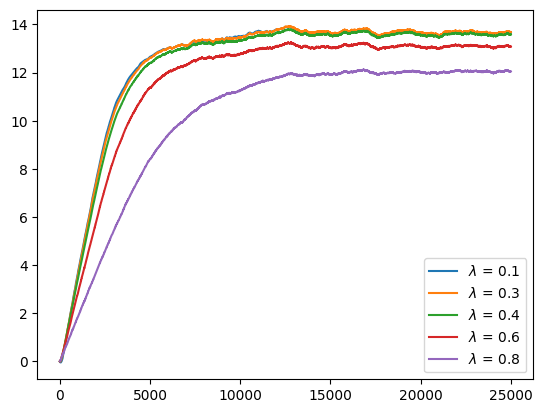

In [4]:
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm
import gymnasium as gym
import sys


episodes = 25000
gamma = 0.95
alpha = 0.05
length = 7
bootstrap = False
x0 = 2
m = 15
kappa = 2

agent1 = QRTDlAgent(m = m,obs_space=length,l = .1 ,gamma = gamma, alpha = alpha, x0 = x0, bootstrap=bootstrap, kappa = kappa)
agent2 = QRTDlAgent(m = m,obs_space=length,l = .3 ,gamma = gamma, alpha = alpha, x0 = x0, bootstrap=bootstrap, kappa = kappa)
agent3 = QRTDlAgent(m = m,obs_space=length,l = .4 ,gamma = gamma, alpha = alpha, x0 = x0, bootstrap=bootstrap, kappa = kappa)
agent4 = QRTDlAgent(m = m,obs_space=length,l = .6 ,gamma = gamma, alpha = alpha, x0 = x0, bootstrap=bootstrap, kappa = kappa)
agent5 = QRTDlAgent(m = m,obs_space=length,l = .8 ,gamma = gamma, alpha = alpha, x0 = x0, bootstrap=bootstrap, kappa = kappa)


agents = [agent1,agent2,agent3, agent4, agent5]

env = RandomWalk()
vs = {agent: [] for agent in agents}

for episode in tqdm(range(episodes)):
    obs, _ = env.reset()
    for agent in agents:
        vs[agent].append(agent.q[3].theta.mean())
        agent.reset(x0 = obs)

    done = False
    prev = length // 2
    while not done:
        action = np.random.randint(2)
        info = env.step(action)

        obs = info[0]
        reward = info[1]
        done = info[2]

        for agent in agents:
            agent.update(x_n=obs,x=prev, r = reward, done = done)
        prev = obs



for agent in agents:
    plt.plot(range(episodes), vs[agent], label=f'$\lambda$ = {agent.l}')
plt.legend()
plt.show()


In [17]:
agent1.q[3].theta

array([10.55531054, 11.06590604, 11.40123588, 11.68302715, 11.94329689,
       12.22345887, 12.51105126, 12.83119462, 13.21180896, 13.65739179,
       14.1989751 , 14.81411197, 15.4317169 , 16.0655693 , 16.92494612])

<>:52: SyntaxWarning: invalid escape sequence '\l'
<>:52: SyntaxWarning: invalid escape sequence '\l'
/tmp/ipython-input-295618120.py:52: SyntaxWarning: invalid escape sequence '\l'
  plt.plot(range(episodes), vs[agent], label=f'$\lambda$ = {agent.l}')
100%|██████████| 10000/10000 [05:46<00:00, 28.88it/s]


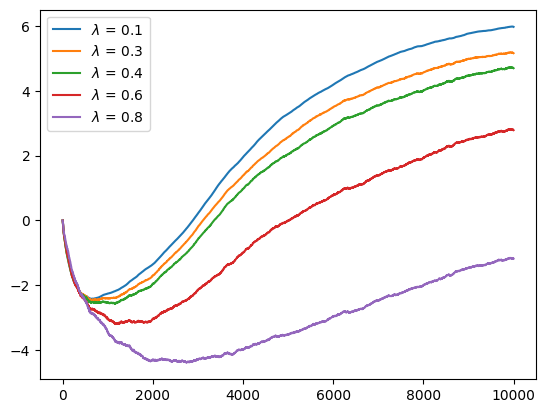

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm
import gymnasium as gym
import sys


episodes = 10000
gamma = 0.95
alpha = 0.05
length = 7
bootstrap = False
x0 = 2
m = 10
kappa = 1

agent1 = QRTDlAgent(m = m,obs_space=length,l = .1 ,gamma = gamma, alpha = alpha, x0 = x0, bootstrap=bootstrap, kappa = kappa)
agent2 = QRTDlAgent(m = m,obs_space=length,l = .3 ,gamma = gamma, alpha = alpha, x0 = x0, bootstrap=bootstrap, kappa = kappa)
agent3 = QRTDlAgent(m = m,obs_space=length,l = .4 ,gamma = gamma, alpha = alpha, x0 = x0, bootstrap=bootstrap, kappa = kappa)
agent4 = QRTDlAgent(m = m,obs_space=length,l = .6 ,gamma = gamma, alpha = alpha, x0 = x0, bootstrap=bootstrap, kappa = kappa)
agent5 = QRTDlAgent(m = m,obs_space=length,l = .8 ,gamma = gamma, alpha = alpha, x0 = x0, bootstrap=bootstrap, kappa = kappa)


agents = [agent1,agent2,agent3, agent4, agent5]

env = RandomWalk()
vs = {agent: [] for agent in agents}

for episode in tqdm(range(episodes)):
    obs, _ = env.reset()
    for agent in agents:
        vs[agent].append(agent.q[3].mean())
        agent.reset(x0 = obs)

    done = False
    prev = length // 2
    while not done:
        action = np.random.randint(2)
        info = env.step(action)

        obs = info[0]
        reward = info[1]
        done = info[2]

        for agent in agents:
            agent.update(x_n=obs,x=prev, r = reward, done = done)
        prev = obs



for agent in agents:
    plt.plot(range(episodes), vs[agent], label=f'$\lambda$ = {agent.l}')
plt.legend()
plt.show()
